## FACET2e BMAD simple example

You will need to install pytao, BMAD, and openpmd-beamphysics (as well as standard libraries like numpy, matplotlib and pandas)

 conda install -c conda-forge bmad
 conda install -c conda-forge pytao, openpmd-beamphysics

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

from plotNMM import plotNMM
from IPython.display import display

#needed for lattice_init
#%env FACET2_LATTICE /u/ar/dcesar/notebooks/facet_bmad
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample


In [2]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches

In [3]:
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

# Start tao

In [4]:
#tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE'])) 

## Plot single particle twiss

In [5]:
elements=tao.lat_ele_list();
#tao.lat_list(elements[0],'ElementType')
#tao.ele_gen_attribs(elements[0])

In [6]:
floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)
floorplan[::25].head(7)

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
1,1,DL00,Drift,-0.86905,-0.86905,10.69357,0.0,1001.56206,-0.61087,0.0,0.0
26,26,DL01H,Drift,1.03220,0.09012,9.60305,0.0,1003.11948,-0.61087,0.0,0.0
51,51,L0BF#2,Lcavity,5.25643,0.33713,7.18014,0.0,1006.57976,-0.61087,0.0,0.0
76,76,QE10441,Quadrupole,8.50702,0.10800,5.31568,0.0,1009.24248,-0.61087,0.0,0.0
101,101,QE10511#1,Quadrupole,11.14513,0.05400,3.80475,0.0,1011.40031,-0.61087,0.0,0.0
126,126,BPM10581,Monitor,14.40167,0.00000,1.93688,0.0,1014.06791,-0.61087,0.0,0.0
151,151,QB10731#1,Quadrupole,17.73408,0.05340,0.26540,0.0,1016.91774,-0.30543,0.0,0.0


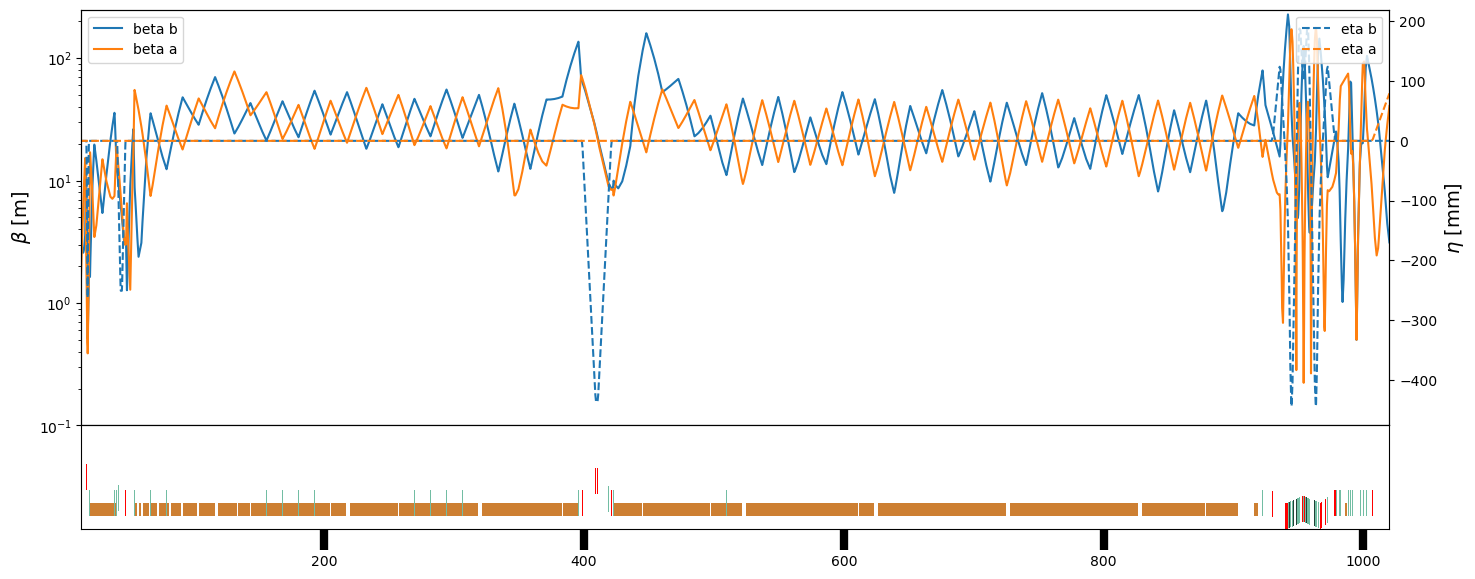

In [7]:
#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])

fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

# Track particles

## Setup

In [8]:
#tao.cmd('set beam_init n_particle = 10000'); # limit to 10k particles for now

In [9]:
#numMacroParticles = 100000
#tao.cmd(f"set beam_init n_particle = {numMacroParticles}") # limit to 10k particles for now

#Change tracking start/end
#tao.cmd('set beam_init track_end = ENDDL10')
tao.cmd('set beam_init track_end = PENT')
#Can see present track_start and track_end values with `show beam`



#Optional: Enable CSR
tao.cmd(f'call {filePath}/bmad/models/f2_elec/scripts/Activate_CSR.tao')
#tao.cmd('csron')
tao.cmd('csroff')

[]

Before match
{'alpha_x': -7.990788473328799, 'beta_x': 36.23004898433273, 'gamma_x': 1.790025192997371, 'emit_x': 3.045268971323036e-08, 'eta_x': -0.0017376422414646206, 'etap_x': -0.0004062503450052696, 'norm_emit_x': 3.6946218044711316e-06}
{'alpha_y': -8.019313309992421, 'beta_y': 36.37269082964837, 'gamma_y': 1.7955610232330173, 'emit_y': 3.0511848423318116e-08, 'eta_y': -0.0017629506825284854, 'etap_y': -0.00040771104033566775, 'norm_emit_y': 3.7017991363348466e-06}


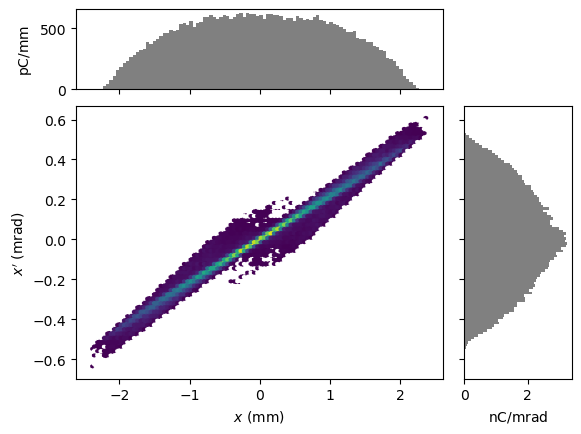

After match
{'alpha_x': -3.1624833699756145, 'beta_x': 48.830608204617626, 'gamma_x': 0.225295188199847, 'emit_x': 3.045269109296084e-08, 'eta_x': -0.002017299157353142, 'etap_x': -0.00015046060622084912, 'norm_emit_x': 3.6946218048862244e-06}
{'alpha_y': -4.387613016732606, 'beta_y': 51.2137105551828, 'gamma_y': 0.3954243456501904, 'emit_y': 3.051184979868751e-08, 'eta_y': -0.0020919299089143246, 'etap_y': -0.00019525268901777348, 'norm_emit_y': 3.7017991358964597e-06}


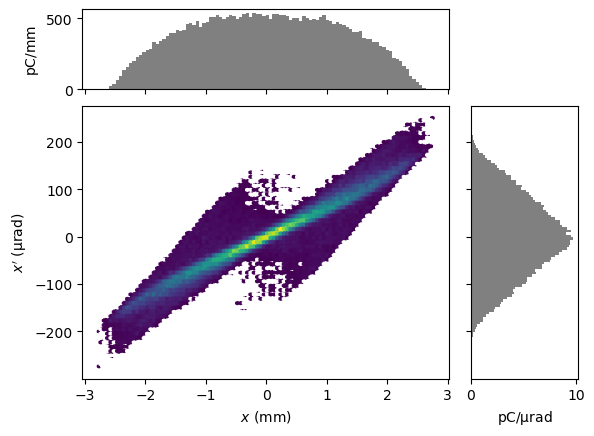

In [10]:
#P = ParticleGroup('/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/beams/L0AFEND.h5')
#P = ParticleGroup('/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch.h5')
#P = ParticleGroup('/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample.h5')
#P = ParticleGroup(f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample.h5')
P = ParticleGroup(f'{filePath}/bmad/beams/L0AFEND.h5')

# === For original example beam ===
print("Before match")
print(P.twiss(plane='x'))
print(P.twiss(plane='y'))
display(plotNMM(P, 'x', 'xp',bins=100))

#P.data.update(resample_particles(P, n=numMacroParticles))

#P.gamma=P.gamma-np.mean(P.gamma)+tao.lat_list('L0AFEND','ele.e_tot')[0]*1e-6/0.511;
P.twiss_match(plane='x',beta=tao.lat_list('L0AFEND','ele.a.beta'),alpha=tao.lat_list('L0AFEND','ele.a.alpha'),inplace=True)
P.twiss_match(plane='y',beta=tao.lat_list('L0AFEND','ele.b.beta'),alpha=tao.lat_list('L0AFEND','ele.b.alpha'),inplace=True)


print("After match")
print(P.twiss(plane='x'))
print(P.twiss(plane='y'))
display(plotNMM(P, 'x', 'xp',bins=100))

# === For 2024-02-16_2bunch ===
#P.t=P.t-np.mean(P.t) #This is sloppy because beam weights are not used!!!

#numMacroParticles = 10000
#P.data.update(resample_particles(P, n=numMacroParticles))

P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')


P.plot('delta_t', 'energy',bins=300)
P.plot('x', 'y',bins=100)

In [11]:
tao.cmd("show ele L0AFEND")

['Element # 37',
 'Element Name: L0AFEND',
 'Key: Marker',
 'S_start, S:      4.127448,      4.127448',
 'Ref_time_start, Ref_time:  1.378376E-08,  1.378376E-08',
 '',
 'Attribute values [Only non-zero values shown]:',
 '    1  L                           =  0.0000000E+00 m',
 '    7  OSC_AMPLITUDE               =  0.0000000E+00 m',
 '   24  TILT_CALIB                  =  0.0000000E+00 rad',
 '   25  DE_ETA_MEAS                 =  0.0000000E+00',
 '   53  P0C                         =  6.3997960E+07 eV           BETA                        =  9.9996812E-01',
 '   54  E_TOT                       =  6.4000000E+07 eV           GAMMA                       =  1.2524488E+02',
 '   64  REF_TIME_START              =  1.3783756E-08 sec      50  DELTA_REF_TIME              =  0.0000000E+00 sec',
 '',
 '       TRACKING_METHOD              =  Bmad_Standard             APERTURE_AT                =  Exit_End',
 '       MAT6_CALC_METHOD             =  Auto                      APERTURE_TYPE          

In [12]:
"""
P = ParticleGroup(f'{filePath}/bmad/beams/L0AFEND.h5')
numMacroParticles = 10000
P.data.update(resample_particles(P, n=numMacroParticles))

print("As imported")
display(plotNMM(P, 'x', 'xp',bins=100))

twissFrac = 0.7;

print(P.twiss(plane="x",fraction=twissFrac))

P.twiss_match(plane='x',beta=80,alpha=-5,inplace=True)

print(P.twiss(plane="x",fraction=twissFrac))

print(P.twiss(plane="y",fraction=twissFrac))

P.twiss_match(plane='y',beta=80,alpha=-7,inplace=True)

print(P.twiss(plane="y",fraction=twissFrac))




P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')

              
print("\nFinal")
display(plotNMM(P, 'x', 'xp',bins=100))
display(plotNMM(P, 'delta_t', 'energy',bins=100))
display(plotNMM(P, 'x', 'y',bins=100))
"""
;


''

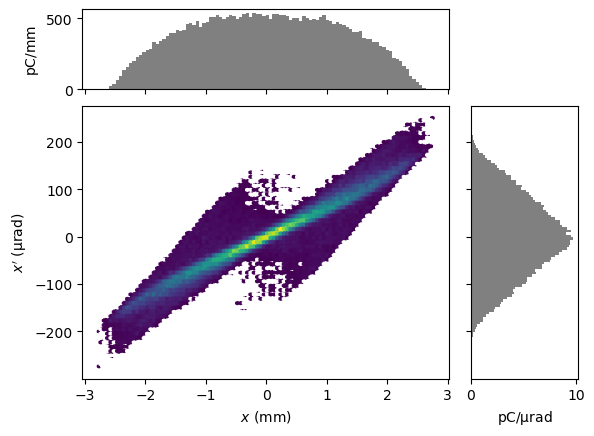

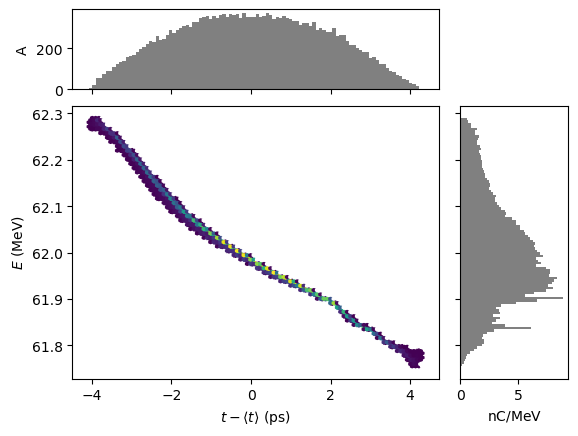

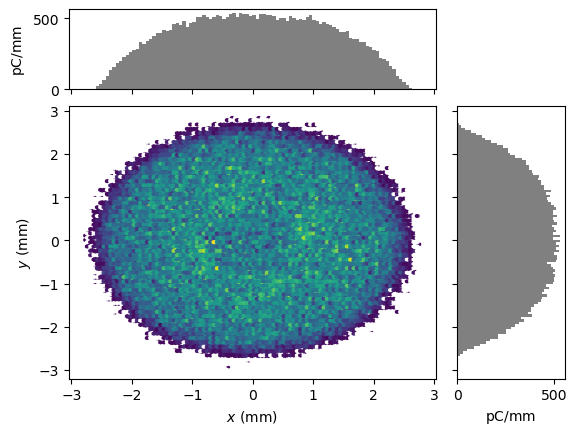

[]

In [13]:
tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')# IF you want to change the beam to the new matched beam at the start
#tao.cmd('set beam_init position_file=/Users/cemma/Downloads/facet2-lattice/bmad/beams/L0AFEND.h5')# 
tao.cmd('reinit beam')

display(plotNMM(P, 'x', 'xp',bins=100))
display(plotNMM(P, 'delta_t', 'energy',bins=100))
display(plotNMM(P, 'x', 'y',bins=100))

tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

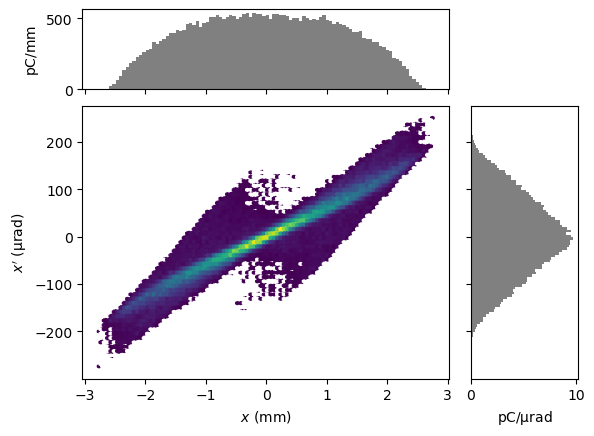

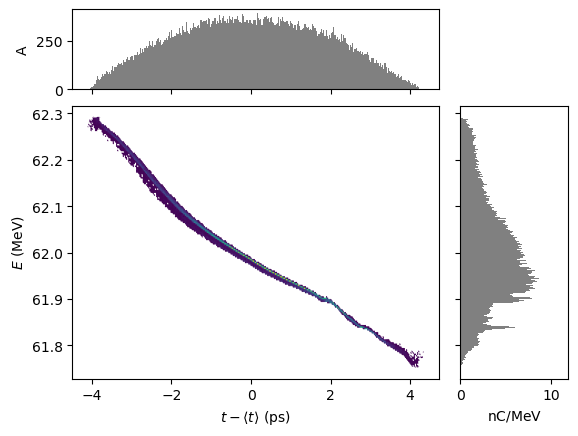

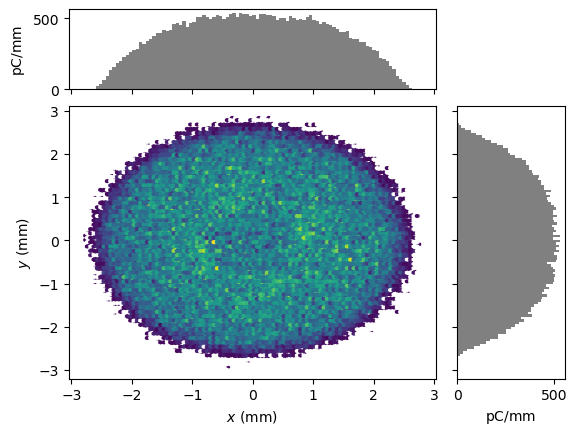

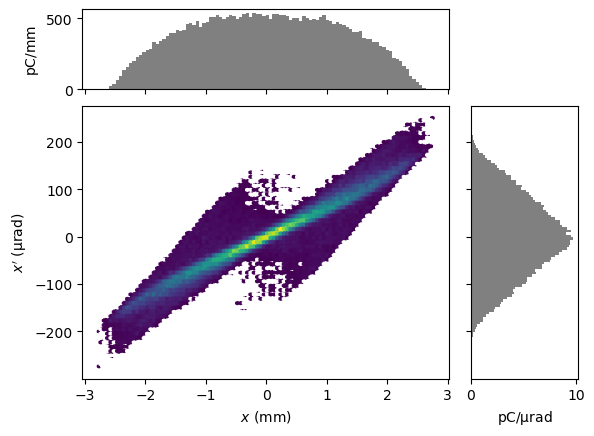

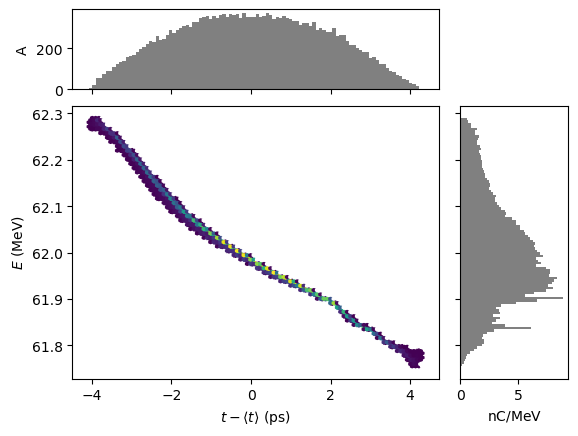

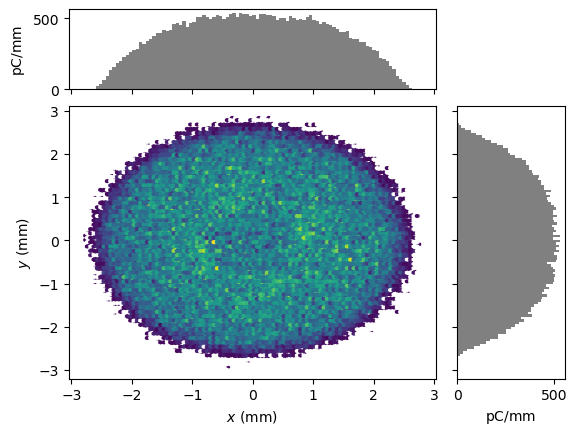

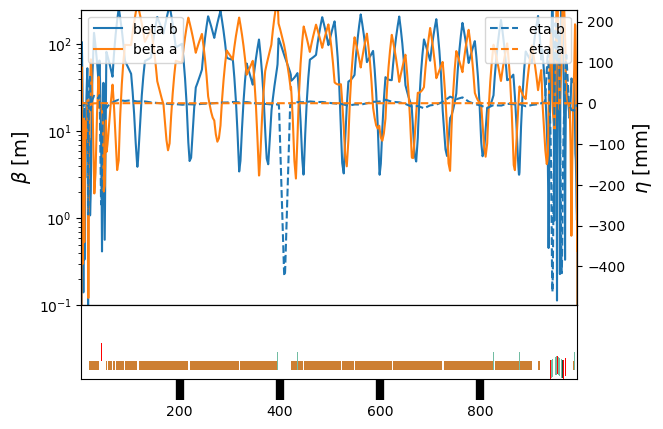

In [14]:
bunch_beta_y=np.array([tao.bunch_params(x)['twiss_beta_y'] for x in floorplan.Index])
bunch_beta_x=np.array([tao.bunch_params(x)['twiss_beta_x'] for x in floorplan.Index])
bunch_etot=np.array([tao.bunch_params(x)['centroid_p0c']*0.511 for x in floorplan.Index])
bunch_eta_y=np.array([tao.bunch_params(x)['twiss_eta_y'] for x in floorplan.Index])
bunch_eta_x=np.array([tao.bunch_params(x)['twiss_eta_x'] for x in floorplan.Index])

# Plot twiss if you want
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,bunch_beta_x,label='beta b')
ax.semilogy(s,bunch_beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,bunch_eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,bunch_eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=tao.ele_head('L0AFEND')['s']
zmax=tao.ele_head('PENT')['s']

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig(savefolder+'beamline'+savestem,transparent=False,bbox_inches='tight')

In [15]:
#These more general match strings might cause problems by including both lords and slaves!
L1MatchStrings = ["K11_1*", "K11_2*"]
L2MatchStrings = ["K11_4*", "K11_5*", "K11_6*", "K11_7*", "K11_8*", "K12_*", "K13_*", "K14_*"]
L3MatchStrings = ["K15_*", "K16_*", "K17_*", "K18_*", "K19_*"]

#Therefore, use lat_list and these general search strings to get specific elements
#Recall that, by default, lat_list has the flag "-track_only" so lords are not included
#But some of the tracking elements are super_slaves which cannot be `set`

#"-array_out" flag is on by default but if flags are edited, need to re-add manually to get numeric values back

L1MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L1MatchStrings ] )
L2MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L2MatchStrings ] )
L3MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L3MatchStrings ] )


selectMarkers  = np.array(["ENDDL10", "BEGBC11_1", "BC11CEND", "BEGBC14_1", "ENDBC14_2", "BEGBC20", "ENDBC20", "PENT"])

def getEnergyChangeFromElements(activeMatchStrings):
    #VOLTAGE is just gradient times length; need to manually include phase info
    voltagesArr = [tao.lat_list(i, "ele.VOLTAGE", flags="-no_slaves -array_out") for i in activeMatchStrings]
    voltagesArr = np.concatenate(voltagesArr)
    
    angleMultArr = [tao.lat_list(i, "ele.PHI0", flags="-no_slaves -array_out") for i in activeMatchStrings]
    angleMultArr = np.concatenate(angleMultArr)
    angleMultArr = [np.cos(i * (2*3.1415) ) for i in angleMultArr] #Recall Bmad uses units of 1/2pi

    return( np.dot(voltagesArr, angleMultArr) )


def setLinacGradientAuto(activeMatchStrings, targetVoltage): 
    #Set to a fixed gradient so everything is the same. Not exactly physical but probably close
    baseGradient = 1.0e7
    for i in activeMatchStrings: tao.cmd(f'set ele {i} GRADIENT = {baseGradient}')
    
    #See the resulting voltage gain
    voltageSum  = getEnergyChangeFromElements(activeMatchStrings)
    
    #print(voltageSum/1e6)
    
    #Uniformly scale gradient to hit target voltage
    for i in activeMatchStrings: tao.cmd(f'set ele {i} GRADIENT = {baseGradient*targetVoltage/voltageSum}')
    
    voltageSum  = getEnergyChangeFromElements(activeMatchStrings)
    
    #print(voltageSum/1e6)

def setLinacPhase(activeMatchStrings, phi0Deg):
    for i in activeMatchStrings: tao.cmd(f'set ele {i} PHI0 = {phi0Deg / 360.}')

#Broken! If you comma separate too many values it just starts ignoring them...
#def printETOTValues(activeElements):
#    printThing = tao.cmd(f"show lat {','.join(activeElements)} -att E_TOT");
#    [print(row) for row in printThing];

#Broken! If you comma separate too many values it just starts ignoring them...
#def printArbValues(activeElements, attString):
#    printThing = tao.cmd(f"show lat {','.join(activeElements)} -att {attString}");
#    [print(row) for row in printThing];

def printArbValues(activeElements, attString):
    #The .tolist() is because of issues when activeElements is a numpy array
    namesList = [ tao.lat_list(i, "ele.name", flags="-no_slaves -array_out") for i in activeElements.tolist() ]
    namesList = np.concatenate(namesList)
    valuesList = [ tao.lat_list(i, f"ele.{attString}",flags="-no_slaves -array_out") for i in activeElements.tolist() ]
    valuesList = np.concatenate(valuesList) / 1e9
    
    printThing = np.transpose([namesList, valuesList])
    display(pd.DataFrame(printThing))

"""
#print("\n Starting point \n")
printETOTValues(selectMarkers)
#printArbValues( L1MatchStrings, "GRADIENT" )
#print(getEnergyChangeFromElements(L1MatchStrings))

#print("\n Changed phase \n")
setLinacPhase(        L1MatchStrings, -19 )
#printArbValues( L1MatchStrings, "GRADIENT" )
#print(getEnergyChangeFromElements(L1MatchStrings))

#print("\n Changed gradient \n")
setLinacGradientAuto( L1MatchStrings, 0.335e9 - 0.125e9 )
#printArbValues( L1MatchStrings, "GRADIENT" )
#print(getEnergyChangeFromElements(L1MatchStrings))



print("\n Next step \n")
printETOTValues(selectMarkers)
setLinacPhase(        L2MatchStrings, -37 ) 
printArbValues( L1MatchStrings, "GRADIENT" )
setLinacGradientAuto( L2MatchStrings, 4.5e9 - 0.335e9 )

printETOTValues(selectMarkers)
setLinacPhase(        L3MatchStrings, 0 )
setLinacGradientAuto( L3MatchStrings, 10.0e9 - 4.5e9 )
"""

printArbValues(selectMarkers, "E_TOT")


,0,1
0,ENDDL10,0.12499999999999989
1,BEGBC11_1,0.3350000000000752
2,BC11CEND,0.3350000000000752
3,BEGBC14_1,4.500000000001358
4,ENDBC14_2,4.500000000001358
5,BEGBC20,10.000000000002878
6,ENDBC20,10.000000000002878
7,PENT,10.000000000002878


,0,1
0,ENDDL10,0.12350000000000005
1,BEGBC11_1,0.3334992131406078
2,BC11CEND,0.3334992131406078
3,BEGBC14_1,4.498427257401253
4,ENDBC14_2,4.498427257401253
5,BEGBC20,9.998427257402108
6,ENDBC20,9.998427257402108
7,PENT,9.998427257402108


L1 phase: -20
L2 phase: -40
Final energy: 10000.215674293173 MeV


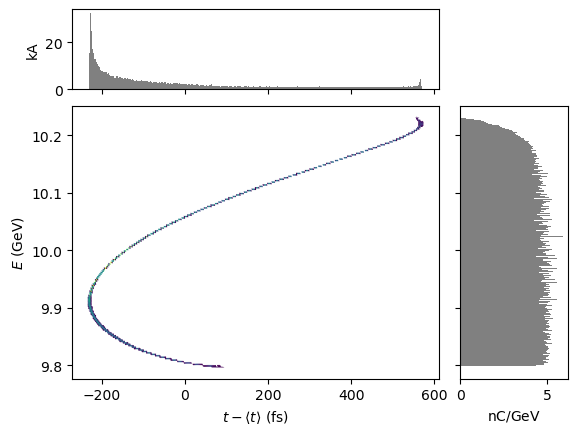

In [16]:
plt.ioff() #Stop P.plot() from outputting to the window

outputData = pd.DataFrame()

for L1AssertPHI0 in np.arange(-20,-18,2):
    for L2AssertPHI0 in np.arange(-40,-35,5):
#for L1AssertPHI0 in np.arange(-22,-16,2):
#    for L2AssertPHI0 in np.arange(-55,-30,5):
        #tao.cmd('set lattice model = design') #Undo any previous changes [Careful with this! It will turn things like CSR back off]
        
        # === Make changes to base lattice ===
        tao.cmd('set ele L0BF PHI0 = 0') #DNT. "loadNominalValues_2Bunch.m" had this set to zero
        tao.cmd('set ele L0BF VOLTAGE = 5.95e7') #DNT. Base value was 7.1067641E+07, new value set to change output energy to 125 MeV (down from 136.5 MeV)
    
        #L1AssertPHI0 = -19 #DNT. "loadNominalValues_2Bunch.m" had this set to -19 degrees
        setLinacPhase(        L1MatchStrings, L1AssertPHI0 ) 
        setLinacGradientAuto( L1MatchStrings, 0.335e9 - 0.125e9 ) 
    
        #L2AssertPHI0 = -37 #DNT. "loadNominalValues_2Bunch.m" had this set to -37 degrees
        setLinacPhase(        L2MatchStrings, L2AssertPHI0 ) 
        setLinacGradientAuto( L2MatchStrings, 4.5e9 - 0.335e9 )
    
        setLinacPhase(        L3MatchStrings, 0 )
        setLinacGradientAuto( L3MatchStrings, 10.0e9 - 4.5e9 )
    
        printArbValues(selectMarkers, "E_TOT")
        
        #A useful command to run in a console window with the same kernel
        #The lattice recalculates E_TOT at each of these `set` commands
        #    tao.cmd("show lat K11* -att GRADIENT -att E_TOT -att PHI0")
        #tao.cmd("show lat BEGBC14_1 -att E_TOT")
        #tao.cmd("show lat BEGBC20 -att E_TOT")

        
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
        
        P = ParticleGroup(data=tao.bunch_data('ENDBC20'))
        # Select out live particles
        P = P[P.status==1]
        P.drift_to_z()

        print(f"L1 phase: {L1AssertPHI0}")
        print(f"L2 phase: {L2AssertPHI0}")
        print(f"Final energy: {np.mean(P.energy/1e6)} MeV")
        outputFig = plotNMM(P, 'delta_t', 'energy',bins=300);
        display(outputFig)
        #P.plot('x', 'y',bins=100)
        #P.slice_plot('norm_emit_x')
    
        #Collect desired data as a pandas Series
        tmpData = pd.Series({
            "L1Phase": L1AssertPHI0,
            "L2Phase": L2AssertPHI0,
            "P": P,
        #    "fig": outputFig
        })
    
        #Convert the Series to a DataFrame, transpose it so it's the right orientation, then append it to the overall output
        outputData = pd.concat([outputData, tmpData.to_frame().T])

In [17]:
"""
#2024-03-07 I spent two hours trying to deal with plotting in a loop (using OpenPMD plot()) and failed
#Best workaround I found is using a title...
#plt.ioff()
plt.ion()
for i in range(0, len(outputData)):
    # Step 1: Clear previous figures
    #plt.close('all')

    #plt.ion()
    plt.suptitle(f'L1 = {outputData.iat[i, 0]}, L2 = {outputData.iat[i, 1]}', fontsize=16)
    outputData.iat[i, 2].plot('delta_t', 'energy',bins=300)
    #plt.ioff()
    
    # Clear the figure after displaying, to ensure it doesn't accumulate in memory
    #plt.close(fig)
"""
;

''

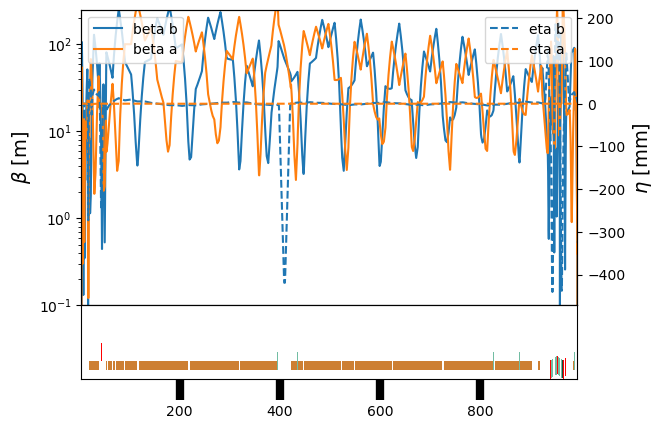

In [18]:
bunch_beta_y=np.array([tao.bunch_params(x)['twiss_beta_y'] for x in floorplan.Index])
bunch_beta_x=np.array([tao.bunch_params(x)['twiss_beta_x'] for x in floorplan.Index])
bunch_etot=np.array([tao.bunch_params(x)['centroid_p0c']*0.511 for x in floorplan.Index])
bunch_eta_y=np.array([tao.bunch_params(x)['twiss_eta_y'] for x in floorplan.Index])
bunch_eta_x=np.array([tao.bunch_params(x)['twiss_eta_x'] for x in floorplan.Index])

# Plot twiss if you want
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,bunch_beta_x,label='beta b')
ax.semilogy(s,bunch_beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,bunch_eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,bunch_eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=tao.ele_head('L0AFEND')['s']
zmax=tao.ele_head('PENT')['s']

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig(savefolder+'beamline'+savestem,transparent=False,bbox_inches='tight')